In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from matplotlib.ticker import ScalarFormatter
from scipy.interpolate import CubicSpline
import mpmath

In [91]:
colors = plt.colormaps['plasma'].resampled(85)
mpmath.mp.dps = 50

In [92]:
f =  ScalarFormatter(useOffset=False, useMathText=True)
f.set_scientific(True)
f.set_powerlimits((0, 0))

def sci_notation(x):
    if x == 0:
        return "0"
    else:
        formatted = f"{x:.2e}"  # Converte in notazione scientifica
        coefficient, exponent = formatted.split('e')
        exponent = int(exponent)  # Converti l'esponente a intero
        return f"${coefficient} \\times 10^{{{exponent}}}$"  # Notazione LaTeX

In [93]:
K = 1.380649e-23 # J / K
vc = 299792458 #m / s
h_pl = 6.62607015e-34 #J*s
T = 2.72548 #K

In [94]:
z1 = np.geomspace(1.0e+2,5.0e+6,500)

In [95]:
folder = 'outputs/fullgreen3/batch/PDE-non-linear'
x = []
DT = []
DI_N = []

z = []
Te = []
Tz = []

for i in range (len(z1)):
    if ((i>8) and (i<99)):
        file_path = os.path.join(folder, f"Dn.delta-z_z_heat_0{i+1}.dat")
    elif(i<9):
        file_path = os.path.join(folder, f"Dn.delta-z_z_heat_00{i+1}.dat")
    else:
        file_path = os.path.join(folder, f"Dn.delta-z_z_heat_{i+1}.dat")
    op = pd.read_csv(file_path, skiprows=6, delimiter=' ', header=None)


    a = op.iloc[:, 0].values
    x.append(a)
    b = op.iloc[:, 4].values
    DT.append(b)
    e = op.iloc[:, 6].values
    DI_N.append(e)


    if ((i>8) and (i<99)):
        file_path2 = os.path.join(folder, f"Temperatures.delta-z_z_heat_0{i+1}.dat")
    elif(i<9):
        file_path2 = os.path.join(folder, f"Temperatures.delta-z_z_heat_00{i+1}.dat")
    else: 
        file_path2 = os.path.join(folder, f"Temperatures.delta-z_z_heat_{i+1}.dat")

    op2 = pd.read_csv(file_path2, skiprows=6, delimiter=' ', header=None)
    d= op2.iloc[:,0]
    z.append(d)
    e= op2.iloc[:,2]
    Te.append(e)
    f = op2.iloc[:,1]
    Tz.append(f)     

In [96]:
folder = 'outputs/fullgreen3/batch/PDE-non-linear/Greens'

z_vis= []
Jbb =[]

for i in range (len(z1)):
    if ((i>8) and (i<99)):
        file_path = os.path.join(folder, f"Dn_0.delta-z_z_heat_0{i+1}.dat")
    elif(i<9):
        file_path = os.path.join(folder, f"Dn_0.delta-z_z_heat_00{i+1}.dat")
    else:
        file_path = os.path.join(folder, f"Dn_0.delta-z_z_heat_{i+1}.dat")
    op = pd.read_csv(file_path, skiprows=6, delimiter=' ', header=None)


    op = pd.read_csv(file_path, skiprows= lambda x: x not in [4], delimiter=' ', header=None)
    Jbb.append(op.iat[0,10])
    z_vis.append(op.iat[0,1])

J_spl = CubicSpline(z_vis, Jbb) 

In [97]:
Jref= lambda x:  np.exp(-(x/1.98e+6)**(5./2.)) 
z_vis = np.array(z_vis)

In [98]:
density = np.zeros(len(z1))
temp = np.zeros(len(z1))

rho_cmb = 8 * (np.pi)**5*K**4/(15 *vc**3 * h_pl**3)*Tz[499][3590]**4


for j in range (len(z1)):
    for i in range (len(x[j])-1):
        h = x[j][i+1] - x[j][i]
        temp[j] = temp[j] + DI_N[j][i]*h
    density[j] = (4*np.pi*K* Tz[499][3590]  /h_pl/vc) / rho_cmb * 1e-26 * temp[j]  



I = density / (1e-5)


In [129]:
# Differenza centrale
def CD(J, h, xd):
    return ((np.log(J(xd + h)) - np.log(J(xd - h))) / (2 * h))

# Differenza in avanti
def CD_(J, h, xd):
    return ((np.log(J(xd + 2 * h)) - np.log(J(xd + h))) / h)

dfdz= lambda x: Jref(x)* (-5/2 * (x / 1.98e+6)**(5/2- 1)) / 1.98e+6

    

In [111]:
(z_vis[len(z_vis)-1]-z_vis[0]) /5000

999.98

In [ ]:
#cout<<setiosflags(ios::scientific)<<setprecision(10);

h_ = 1e-2 #amplitude of subinterval



der_bbn = []
der_refn = []
   
for i in range (len(z_vis)):
    
    if(z_vis[i]<0 or z_vis[i]==0):
        print(i + "error")
        break
    if(i==0):
        der_bbn.append(CD_(J_spl,h_, z_vis[i]))
        der_refn.append(CD_(Jref,h_, z_vis[i]))
    else:
        der_bbn.append( CD(J_spl,h_, z_vis[i]))
        der_refn.append( CD(Jref,h_, z_vis[i]))
        


    

In [144]:
z_vis[499]

5000000.0

In [145]:
matrix= open("Jbb.dat","w")
matrix.write("########################################################"+"\n")
matrix.write("zh         Jbb"+"\n")
for i in range(len(z_vis)):
    matrix.write(str(z_vis[i])+" "+str(Jbb[i])+"\n")

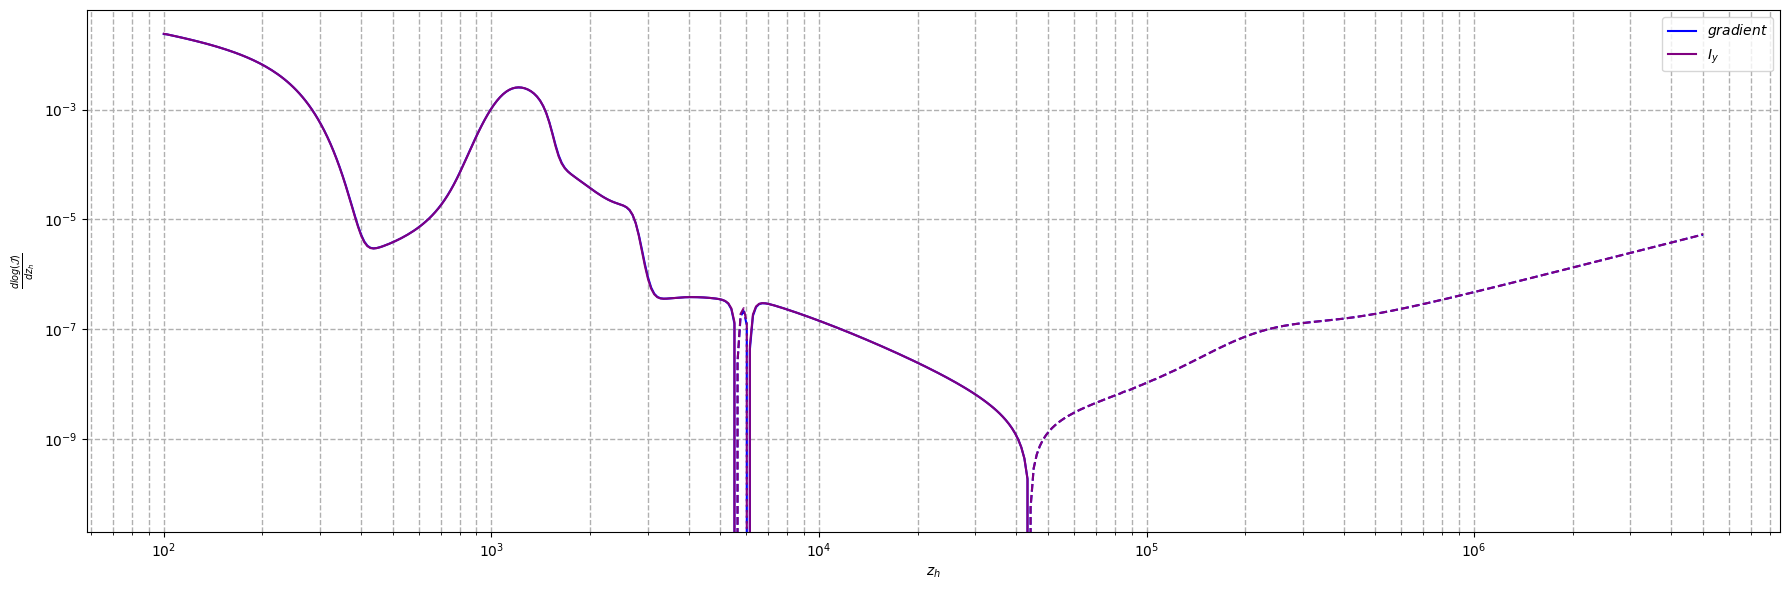

In [ ]:

der_bbn = np.array(der_bbn)

fig, ax = plt.subplots( figsize=(18, 6))
#fig.suptitle(f"Late time visibility function with hubble cooling ")
ax.plot(z_vis, np.gradient(np.log(Jbb),z_vis), color = "blue", label= "$gradient$")
ax.plot(z_vis, -np.gradient(np.log(Jbb),z_vis), color = "blue", linestyle = "dashed")

ax.plot(z_vis, der_bbn, color = "purple", label= "$I_y$")
ax.plot(z_vis, -der_bbn, color = "purple", linestyle = "dashed")

ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim([100, 10000])
ax.set_ylabel("$\\frac{dlog(\mathcal{J})}{dz_h}$")
ax.set_xlabel("$z_h$")
#ax1.set_title("All $\Delta$ I_N curves")
ax.grid(True, which = 'both',  linestyle='--', linewidth=1)
ax.legend()





#ax.yaxis.set_major_formatter(ScalarFormatter())    
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0),useMathText=True) #only y axis, it does not work on the log scale

#ax.xaxis.set_major_formatter(ScalarFormatter())    
#ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0),useMathText=True) #only y axis, it does not work on the log scale

plt.tight_layout()
plt.show()

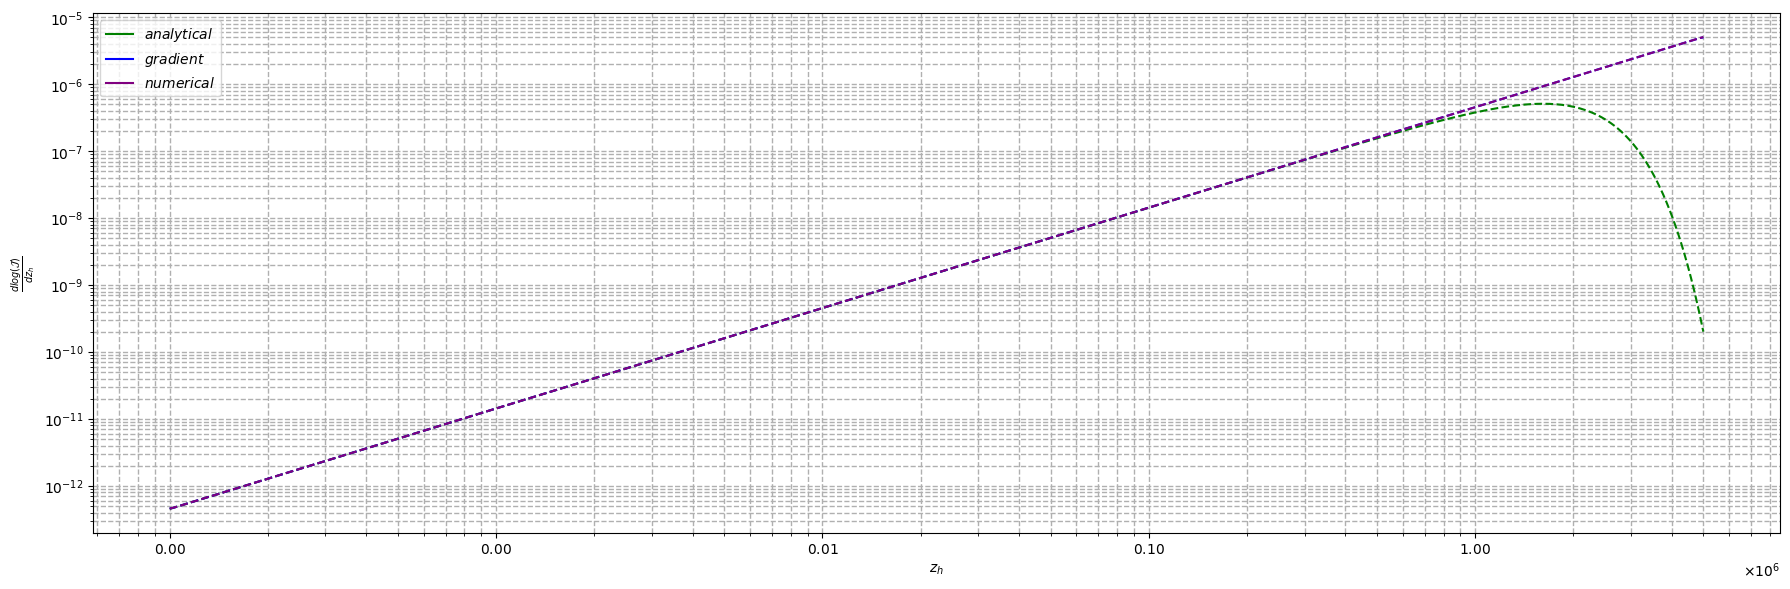

In [ ]:


fig, ax = plt.subplots( figsize=(18, 6))
#fig.suptitle(f"Late time visibility function with hubble cooling ")
ax.plot(z_vis, dfdz(z_vis), color = "green", label= "$analytical$")
ax.plot(z_vis, -dfdz(z_vis), color = "green", linestyle = "dashed")
ax.plot(z_vis, np.gradient(np.log(Jref(z_vis)),z_vis), color = "blue", label= "$gradient$")
ax.plot(z_vis, -np.gradient(np.log(Jref(z_vis)),z_vis), color = "blue", linestyle = "dashed")
ax.plot(z_vis, der_refn, color = "purple", label= "$numerical$")
ax.plot(z_vis, -der_refn, color = "purple", linestyle = "dashed")

ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim([100, 10000])
ax.set_ylabel("$\\frac{dlog(\mathcal{J})}{dz_h}$")
ax.set_xlabel("$z_h$")
#ax1.set_title("All $\Delta$ I_N curves")
ax.grid(True, which = 'both',  linestyle='--', linewidth=1)
ax.legend()





#ax.yaxis.set_major_formatter(ScalarFormatter())    
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0),useMathText=True) #only y axis, it does not work on the log scale

ax.xaxis.set_major_formatter(ScalarFormatter())    
ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0),useMathText=True) #only y axis, it does not work on the log scale

plt.tight_layout()
plt.show()

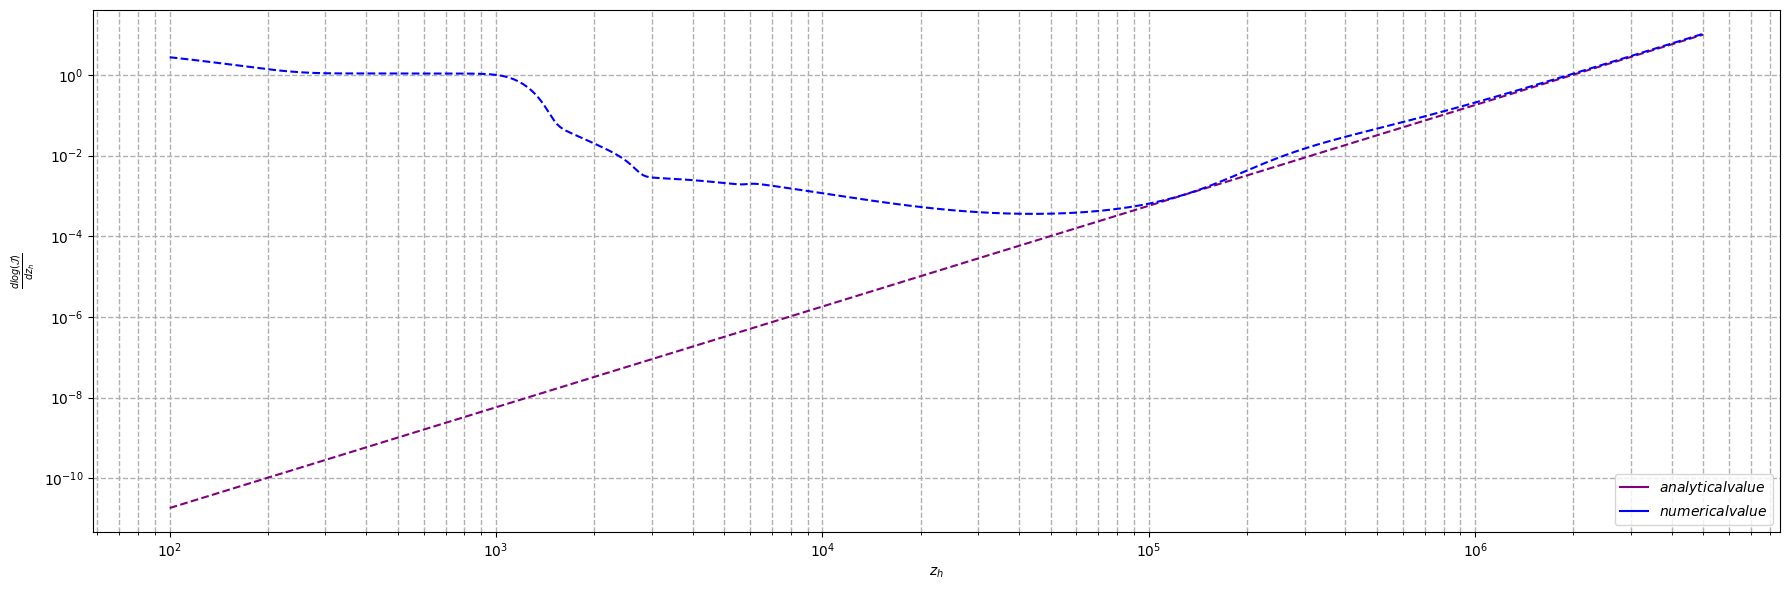

In [156]:
der_ref= np.gradient(np.log(Jref(z_vis)),np.log(z_vis))
der_bb = np.gradient(np.log(Jbb),np.log(z_vis))

log_ref = np.log(Jref(z_vis))
log_bb = np.log(Jbb)

fig, ax = plt.subplots( figsize=(18, 6))
#fig.suptitle(f"Late time visibility function with hubble cooling ")

ax.plot(z_vis, log_ref, color = "purple", label= "$analytical value$")
ax.plot(z_vis, -log_ref, color = "purple", linestyle = "dashed")

ax.plot(z_vis, log_bb, color="blue", label= "$numerical value$")
ax.plot(z_vis, -log_bb, color="blue",  linestyle = "dashed")

ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim([100, 10000])
ax.set_ylabel("$\\frac{dlog(\mathcal{J})}{dz_h}$")
ax.set_xlabel("$z_h$")
#ax1.set_title("All $\Delta$ I_N curves")
ax.grid(True, which = 'both',  linestyle='--', linewidth=1)
ax.legend()





#ax.yaxis.set_major_formatter(ScalarFormatter())    
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0),useMathText=True) #only y axis, it does not work on the log scale

#ax.xaxis.set_major_formatter(ScalarFormatter())    
#ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0),useMathText=True) #only y axis, it does not work on the log scale

plt.tight_layout()
plt.show()

In [157]:
Imu = der_bb/der_ref
Imu2 = Imu[z_vis>2e4]
zvis2 = z_vis[z_vis>2e4]

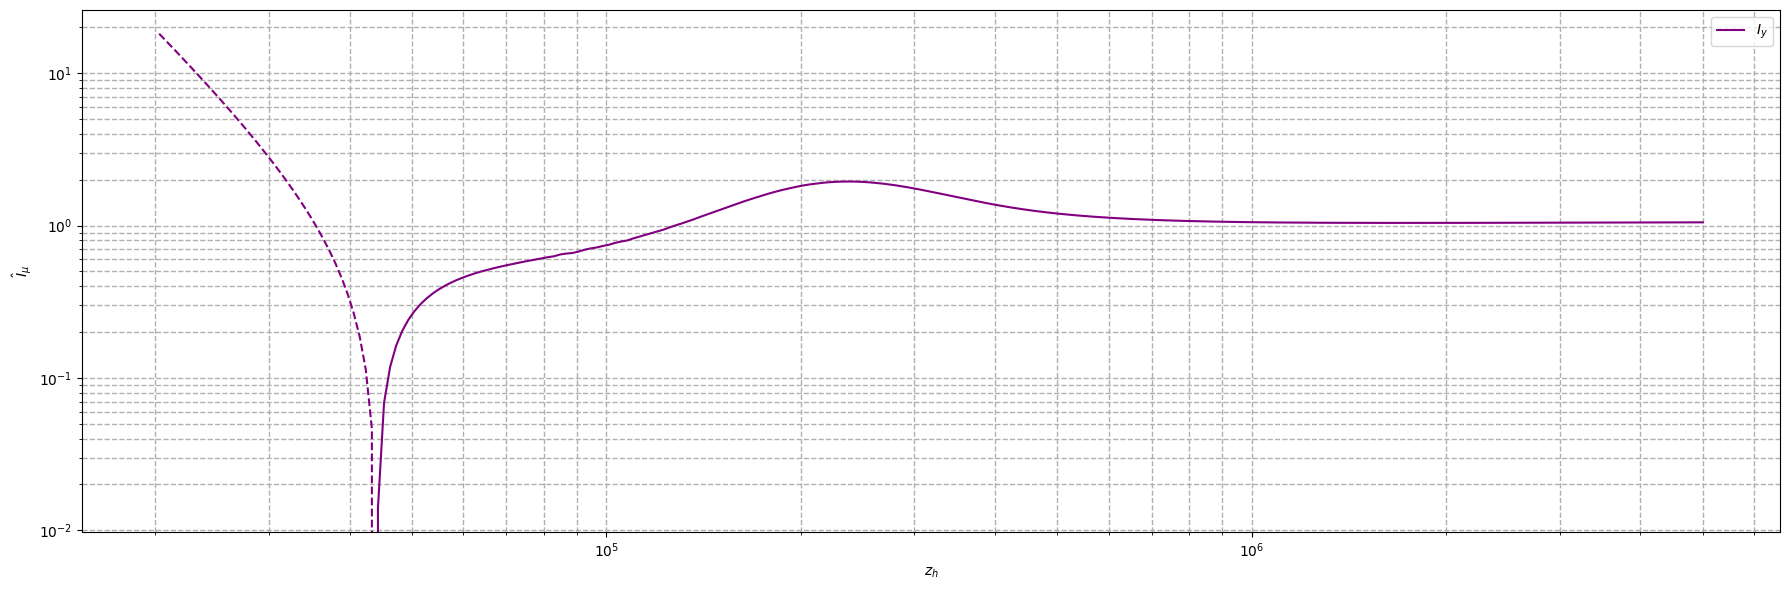

In [158]:
fig, ax = plt.subplots( figsize=(18, 6))
#fig.suptitle(f"Late time visibility function with hubble cooling ")

ax.plot(zvis2, Imu2, color = "purple", label= "$I_y$")
ax.plot(zvis2, -Imu2, color = "purple", linestyle = "dashed")

ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim([50000, 10000])
ax.set_ylabel("$\hat{I}_{\mu}$")
ax.set_xlabel("$z_h$")
#ax1.set_title("All $\Delta$ I_N curves")
ax.grid(True, which = 'both',  linestyle='--', linewidth=1)
ax.legend()





#ax.yaxis.set_major_formatter(ScalarFormatter())    
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0),useMathText=True) #only y axis, it does not work on the log scale

#ax.xaxis.set_major_formatter(ScalarFormatter())    
#ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0),useMathText=True) #only y axis, it does not work on the log scale

plt.tight_layout()
plt.show()

In [160]:
matrix= open("Imu.dat","w")
matrix.write("########################################################"+"\n")
matrix.write("zh         Imu"+"\n")
for i in range(len(z_vis)):
    if(z_vis[i]>2e4):
        matrix.write(str(z_vis[i])+" "+str(Imu[i])+"\n")